# 5. Decision trees 

## Creating a simple tree classifier

In previous modules, we have learned to solve classification problems with the kNN algorithm. However, there are many other alternatives to choose from when building classifiers. Since all of them have their individual strengths and weaknesses, it is useful to know of different options in order to be able to pick the most suitable one for the purpose. In this module, we shall learn to perform classification with **decision trees**.

When contacting a company's customer service by phone, one is often subjected to a series of questions ("Are you a private or business client?" etc.), and asked to perform selections according to the specific issue or problem behind the phone call. Having given answers to these questions, the caller is finally directed to the appropriate service person with the necessary expertise to help or give advice. This is essentially what happens when using decision trees as classifiers: the tree consists of a flowchart-like succession of questions concerning the values of the samples' input features. The answers to these questions determine the route followed by the sample within the tree structure, ending with the final prediction concerning its target class. 

As a first example, we once more employ the iris dataset, and build a decision tree classifier for predicting the "species" feature. In the following code cell, we download the dataset, preprocess the data into inputs and targets, and extract a test set for hold-out validation. The resulting training set consists of 112 samples, and the remaining 38 form the test set. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree  

df = pd.read_csv('datasets/iris/iris.csv')
X = df.drop(['species'], axis = 1) # input features
y = df['species'].astype('category') # target features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20) # extract test set
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(112, 4) (38, 4) (112,) (38,)


Building a decision tree using Scikit-learn library is an easy task: first, one creates an instance of `DecisionTreeClassifier` class, and trains the model using its `fit` method, with the training set features and labels as parameters. The optional parameter `max_depth` restricts the size of the resulting tree structure. 

In [2]:
model = DecisionTreeClassifier(max_depth=2, random_state=20)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=20)

Once the classifier has been constructed, it can easily be visualized as follows:

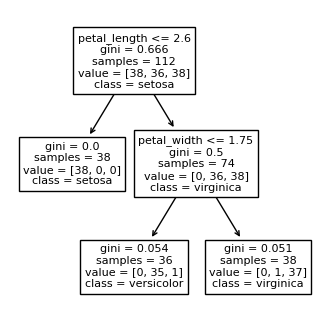

In [3]:
fig = plt.figure(figsize = (4, 4))
plot_tree(model, feature_names = X.keys(), class_names = ['setosa', 'versicolor', 'virginica'])
plt.show()

The uppermost node of the tree is the **root** node, and contains the first question concerning the input features of the sample. In this particular tree, this node checks whether the value of the `petal_length` variable is less than or equal to 2,6 cm. Depending on the binary-valued answer (True/False) to this question, the sample is directed to one of two alternative **child** nodes. 

If the condition is true, the child node on the left is selected. The process then immediately terminates, the node being a **leaf** with the predicted target class "setosa". In our example, this happens with 38 samples (out of the total of 112), and all of them also turn out to have "setosa" as their true class label. The class distribution for the samples in the node is displayed as the "value" array.

The remaining 74 samples, for which the condition in the root node is false, are directed to the right-hand side child node. There they are subjected to a further split, this time according to the value of the variable `petal_width`. Depending on whether this value is less than or equal to 1,75 cm, the process finishes with two leaf nodes, and the target class for the sample is predicted to be either "versicolor" or "virginica", respectively. 

Note that two of the 112 samples in the training set end up with false predictions with this classifier: one of the 36 samples with the predicted class "versicolor" are actually of type "virginica", and one of the 38 samples with the predicted class "virginica" are actually of type "versicolor".

This simple example emphasizes the main advantage of using decision trees as classifiers: they are easy to visualize and interpret, and the operational logic behind the class predictions is entirely transparent. The most important input features are easily recognized: in this example, petal length and petal width appear to indicate the target class fairly well, at least within the training set. This is in contrast to kNN classifiers, where no separate model of the situation is ever constructed; instead, the classification relies on feature-value comparisons between samples. For this reason, kNN algorithms also run into difficulties with large datasets and large numbers of features. When the problems grow in size, decision trees have better scaling properties. Also, decision tree algorithms simplify preprocessing, as they do not require standardization: the feature values are always checked separately, one at a time.   

To assess the performance of our classifier, we test it with previously unseen data in the test set. The sample classes are determined with the `predict` method, and compared with the true labels; the results are presented as a confusion matrix.

In [4]:
from sklearn.metrics import confusion_matrix

preds = model.predict(X_test)
confusion_matrix(y_test, preds)

array([[12,  0,  0],
       [ 0, 14,  0],
       [ 0,  4,  8]], dtype=int64)

From the total of 38 samples in the test set, 34 are found to end up with correct class predictions.
Four test samples of species "virginica", however, are erroneously identified as "versicolor" by our simple model. 

## Building the tree

Next we take a look at the strategy behind building a decision tree. What determines the form of the tree, and how are the binary-valued questions in the nodes selected? Which input features and split values would produce best results? All of this happens automatically, but it is useful to understand the main ideas behind this procedure. 

The standard strategy progresses as follows: start with the root node with all the training samples, and go through the set of alternatives for the first binary question (all the input features, with many different values for the split point). From these alternatives, select the one that produces a division of samples with the most uneven distribution of classes, as quantified in terms of a suitable criterion (to be defined below). Repeat the above procedure with each of the two resulting child nodes and the samples in them, and keep growing the tree further, until some condition for termination is fulfilled; e.g. when all the samples in a node belong to the same class. When this happens, the node becomes a leaf, and the class of the sample is predicted according to the labels of the training samples in that node (with majority voting, if necessary).   

The default criterion in Scikit-learn for selecting optimal questions for decision tree nodes is the **Gini index**, which measures the unevenness of distributions. Consider a problem with $N$ different classes, and that the samples in a given node are distributed among the classes with probabilities $p_{i}$, where the index $i = 1, ..., N$. The Gini index for that node is    

$$
g = 1 - \sum_{i = 1}^{N} p_{i}^2
$$ 
In the optimal situation all the samples belong to one of the classes: the probability of that class is then one, and all the other probabilities are zero. This results in the Gini index of zero. The worst-case scenario (in view of classification), on the other hand, is when all the class probabilities are equal: $p_{i} = 1/N$ for all $i$, and $g = (N-1)/N$. For a split producing two child nodes (one where the split condition is true, and one where it is false), the Gini index is computed for both of them separately. The Gini index for the entire split is then obtained as a weighted average of them:

$$
g_{\rm split} = \frac{n_{\rm T} g_{\rm T} + n_{\rm F} g_{\rm F}}{n_{\rm T} + n_{\rm F}},
$$ 
where the weighting factor $n_{\rm T}$ ($n_{\rm F}$) is the number of samples in node "true" ("false"). The optimal split condition with the smallest value for $g_{\rm split}$ is then selected.

For example, in the above decision tree, the starting class distribution (shown in the root node) in the training set was $p_{setosa} = p_{virginica} =$ 38/112 and $p_{versicolor} =$ 36/112, resulting in the Gini index of 0,666. After the split chosen for that node, the "true" child node has $g_{T} =$ 0, since all the 38 samples ending up there belong to one class, whereas the "false" node has $g_{F}$ = 1 $-$ 0 $-$(36/74)$^{2}-$(38/74)$^{2}\approx$0,5. The Gini index for the entire split is (38$\cdot$0 + 74$\cdot$0,5)/112 $\approx$ 0,33. In this way, the indices for all possible alternative splits are calculated, and the one corresponding to the optimal (smallest) value gets selected. 

## Further issues with decision trees

Let us consider another example, this time with the dataset containing information about passengers on RMS Titanic. First, we preprocess the original dataset by dropping out samples with missing values, and discarding some of the columns containing categorical features:

In [5]:
data = pd.read_csv('datasets/titanic/titanic_orig.csv').dropna()
data = data.drop(columns = ['PassengerId','Name','Ticket','Cabin','Embarked'])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
1,1,1,female,38.0,1,0,71.2833
3,1,1,female,35.0,1,0,53.1000
6,0,1,male,54.0,0,0,51.8625
10,1,3,female,4.0,1,1,16.7000
11,1,1,female,58.0,0,0,26.5500


The leftmost column "Survived" is our binary target variable (0 = did not survive, 1 = survived). Among the input variables there are two continuously varying numerical features (Age, Fare), three discrete-valued numerical features (Pclass, SibSp, Parch), and one categorical feature (Sex). 

**NOTE:** Decision trees in Scikit-learn can only treat numerical input features. Therefore, the string-valued "Sex" column has to be converted to numerical form (0 and 1). For this purpose, we use the pandas `get_dummies` function, which transforms categorical columns to **one-hot-encoded** form:   

In [6]:
pd.get_dummies(data['Sex'], dtype='int64').head()

,female,male
1,1,0
3,1,0
6,0,1
10,1,0
11,1,0


From this, we pick the generated "female" column, and replace the "Sex" column in the original dataframe with its contents. 

In [7]:
data['Sex'] =pd.get_dummies(data['Sex'], dtype='int64')['female']
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
1,1,1,1,38.0,1,0,71.2833
3,1,1,1,35.0,1,0,53.1000
6,0,1,0,54.0,0,0,51.8625
10,1,3,1,4.0,1,1,16.7000
11,1,1,1,58.0,0,0,26.5500


Now we can proceed to extract the sets for training and testing:

In [8]:
X = data.drop(['Survived'], axis = 1) # input features
y = data['Survived'] # target features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(137, 6) (46, 6) (137,) (46,)


Next we generate a decision tree classifier, but this time without restricting the tree depth. The resulting model is seen to be quite complex in structure:

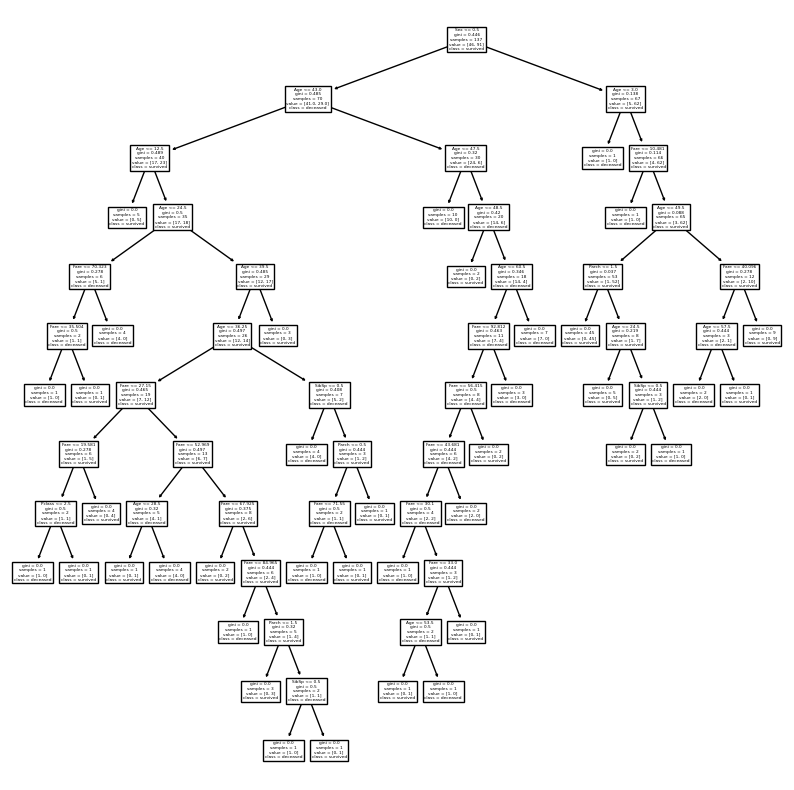

In [9]:
model = DecisionTreeClassifier(random_state=20).fit(X_train, y_train)
fig = plt.figure(figsize = (10, 10))
plot_tree(model, feature_names = X.keys(), class_names = ['deceased', 'survived'])
plt.show()

The tree has been grown to the extent that it is able to predict the classes for all the training samples correctly. However, as discussed in the previous module, very large models often exhibit symptoms of overfitting. Indeed, when tested with new data in the test set, 14 samples out of the total of 46 end up with erroneous predictions: 

In [10]:
preds = model.predict(X_test)
confusion_matrix(y_test, preds)

array([[ 7,  7],
       [ 7, 25]], dtype=int64)

To reduce overfitting, the `max_depth` parameter could again be used to prevent the growing of the tree beyond a predetermined size. In addition to this, there is another alternative approach called **pruning**. This means that the model is first allowed to grow unrestricted, but is then simplified afterwards by replacing splits with leaf nodes. A definite strategy called "cost-complexity pruning" is easily implemented by simply adding a new float-valued parameter `ccp_alpha` when creating the classifier instance; larger values result in more pruning, and a less complex model. More details on cost-complexity pruning can be found in Scikit-learn documentation.  

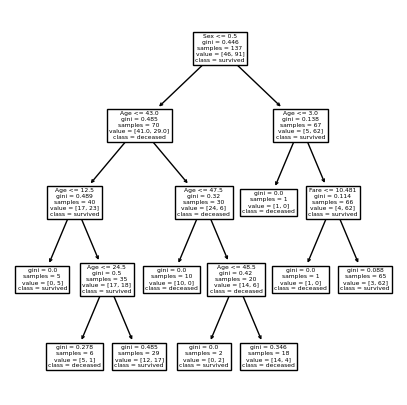

In [11]:
model_pruned = DecisionTreeClassifier(random_state=20, ccp_alpha=0.012).fit(X_train, y_train)
fig = plt.figure(figsize = (5, 5))
plot_tree(model_pruned, feature_names = X.keys(), class_names = ['deceased', 'survived'])
plt.show()

When tested, the pruned model has a slightly better accuracy (see the code cell below). However, the essential improvement is that the pruned model is much easier to interpret than the original complex one.

In [12]:
preds = model_pruned.predict(X_test)
confusion_matrix(y_test, preds)

array([[ 8,  6],
       [ 4, 28]], dtype=int64)

Finally, note that above we have used the same test set twice for assessing the performance of two different models. This has been done only in order to introduce the concept of pruning, and to help understanding its effects - not as an appropriate strategy to follow in actual machine learning projects.   